In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import itertools
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.base import TransformerMixin
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from matplotlib import pylab as plt
plot = True
import shap

In [16]:
#read the data
data1 = pd.read_csv('dual_tariffs.csv')
data2 = pd.read_csv('elec_gas_tariffs.csv')
data2 = data2[data2['EnergyType']==2]

data = pd.concat([data1,data2])
data.dropna(axis=1, how='all',inplace=True)

In [18]:
#compute the yearly cost
std = data.loc[data.MeterType=='STD',:]
e7 = data.loc[data.MeterType=='E7',:]

std.loc[:,'low_cost'] = std['UnitRate1Elec']*2500 + std['StandingChargeElec']*365 + std['MonthlyFee']*12
std.loc[:,'med_cost'] = std['UnitRate1Elec']*4200 + std['StandingChargeElec']*365 + std['MonthlyFee']*12
std.loc[:,'hig_cost'] = std['UnitRate1Elec']*7100 + std['StandingChargeElec']*365 + std['MonthlyFee']*12

e7.loc[:,'low_cost'] = (0.58*e7['UnitRate1Elec']+0.42*e7['UnitRateE7Elec'])*2500 + e7['StandingChargeElec']*365 + e7['MonthlyFee']*12
e7.loc[:,'med_cost'] = (0.58*e7['UnitRate1Elec']+0.42*e7['UnitRateE7Elec'])*4200 + e7['StandingChargeElec']*365 + e7['MonthlyFee']*12
e7.loc[:,'hig_cost'] = (0.58*e7['UnitRate1Elec']+0.42*e7['UnitRateE7Elec'])*7100 + e7['StandingChargeElec']*365 + e7['MonthlyFee']*12

In [19]:
data = pd.concat([std,e7])

In [20]:
data.OnSaleStartDate = pd.to_datetime(data.OnSaleStartDate)
data.loc[:,'OnSaleYear'] = data['OnSaleStartDate'].apply(lambda x:x.year)

data.reset_index(inplace=True)
del data['index']

In [21]:
# FixedTerm processing
data1 = data[data['FixedTerm'].str.contains('onths')==False]
data2 = data[data['FixedTerm'].str.contains('onths')==True]
data1[['OnSaleStartDate']] = data1[['OnSaleStartDate']].apply(pd.to_datetime,utc=True)
data1['FixedTerm'] = pd.to_datetime(data1['FixedTerm'],utc=True)
data1.loc[:,'FixedTerm'] = (data1['FixedTerm']-data1['OnSaleStartDate'])/np.timedelta64(1, 'M')
data1['FixedTerm'] = data1['FixedTerm'].astype(int)

data2['FixedTerm'] = data2['FixedTerm'].str.extract('(\d+)')
data = pd.concat([data1,data2])

In [22]:
#columns to delete
cols = ['OnSaleEndDate', 'RegulatoryStartDate',
       'RegulatoryEndDate', 'ExitFeeEndDate', 'ExitFeeElec',
         'UnitRate1LimitElec','OnSaleStartDate','UnitRate1Elec','StandingChargeElec','MonthlyFee',
        'EnergySupplierKey','SupplierCode','SupplierName','DiscountFromTotalElecFormat','DiscountFromTotal2ElecFormat',
       'UnitRate2Elec', 'UnitRateE7Elec', 'DiscountFromTotalElec','Key', 'StagingKey', 'TariffCode', 'TariffName',
        'DiscountFromTotal2Elec','LoadDate','ExitFeeGas',
       'StandingChargeGas', 'UnitRate1Gas', 'UnitRate1LimitGas',
       'UnitRate2Gas', 'UnitRate2LimitGas', 'UnitRate3Gas',
       'DiscountFromTotalGas', 'DiscountFromTotalGasFormat',
       'DiscountFromTotal2Gas', 'DiscountGasUnits',
       'DiscountGasMaxRelatedPercent', 'DiscountGasPerUnit2',
       'DiscountGasPerUnitMax','InstallationCost', 'DiscountElecUnits',
       'DiscountElecUnitsFormat', 'DiscountElecRelatedPercent',
       'DiscountElecMaxRelatedPercent', 'DiscountElecPerUnit2',
       'DiscountElecPerUnitMax']

#features transform to dummy variables
cols_dum = ['DistId', 'EnergyType', 'IsStandardTariff', 
       'MeterType', 'IsExcluded', 'IsExlusive', 'IsShownToCustomers',
       'IsPaperBilling', 'IsOnlineBilling', 'IsFixed', 'IsGreenTariff',
       'NewCustomersOnly', 'ExistingCustomersOnly', 'OnSaleYear']

In [23]:
data = data.drop(columns = cols)#delete fetures
data = pd.get_dummies(data,columns = cols_dum)#change into dummy variable
data.dropna(inplace=True)

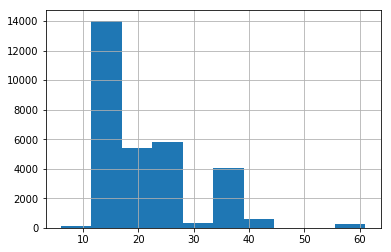

In [24]:
data['FixedTerm'].astype(float).hist()#distribution of 'FixedTerm'

In [25]:
# Fixed Term processing
scaler = MinMaxScaler()
scaler.fit(data[['FixedTerm']])
data['FixedTerm'] = scaler.transform(data[['FixedTerm']])

XGBoost

In [26]:
cols1 = ['low_cost','med_cost','hig_cost']
features = [c for c in data.columns.tolist() if c not in cols1]# features column
goal = 'med_cost'

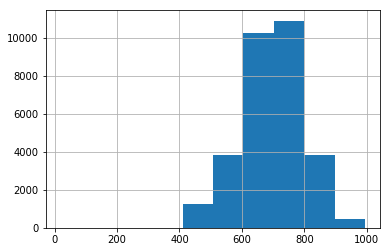

In [27]:
#distribution of yearly cost
data[goal].hist()

In [34]:
X_train, X_test = train_test_split(data, test_size=0.2,random_state = 7)#split dataset 
dtrain = xgb.DMatrix(X_train[features], X_train[goal] + 1)
dvalid = xgb.DMatrix(X_test[features], X_test[goal] + 1)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
dfull = xgb.DMatrix(data[features],data[goal]+1)

In [35]:
# use validation set to choose number of  of trees
params = {
    "eta": 0.02,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgb.train(params, dtrain, 15000, evals = [(dvalid, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:7.69232
[1000]	test-cox-nloglik:6.81508
[2000]	test-cox-nloglik:6.73681
[3000]	test-cox-nloglik:6.70659
[4000]	test-cox-nloglik:6.69594
[5000]	test-cox-nloglik:6.68819
[6000]	test-cox-nloglik:6.68646
[7000]	test-cox-nloglik:6.68179
[8000]	test-cox-nloglik:6.68415
[9000]	test-cox-nloglik:6.68086
[10000]	test-cox-nloglik:6.682
[11000]	test-cox-nloglik:6.68306
[12000]	test-cox-nloglik:6.683
[13000]	test-cox-nloglik:6.68414
[14000]	test-cox-nloglik:6.68614
[14999]	test-cox-nloglik:6.6879


In [36]:
# train final model on the full data set
params = {
    "eta": 0.02,
    "max_depth": 3, 
    "objective": "survival:cox",
    "subsample": 0.5
}
model = xgb.train(params, dfull, 9000, evals = [(dfull, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:9.31027
[1000]	test-cox-nloglik:8.43768
[2000]	test-cox-nloglik:8.35488
[3000]	test-cox-nloglik:8.31862
[4000]	test-cox-nloglik:8.29997
[5000]	test-cox-nloglik:8.28841
[6000]	test-cox-nloglik:8.28064
[7000]	test-cox-nloglik:8.27471
[8000]	test-cox-nloglik:8.2705
[8999]	test-cox-nloglik:8.26705


In [37]:
#calculate the shap values
shap_values = shap.TreeExplainer(model).shap_values(data[features])

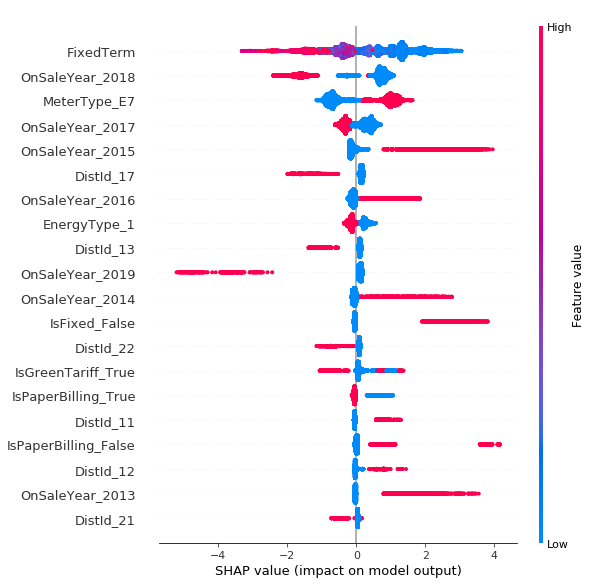

In [38]:
shap.summary_plot(shap_values, data[features])

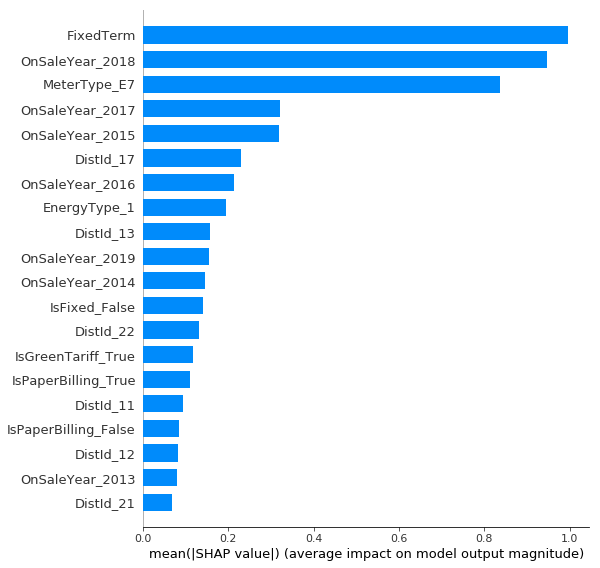

In [39]:
shap.summary_plot(shap_values, data[features], plot_type="bar")

In [40]:
shap.initjs()
shap.force_plot(shap.TreeExplainer(model).expected_value, shap_values[0,:], data[features].iloc[0,:])